# Getting Started

## Import dependencies

In [ ]:
%%capture

%pip install lifelines


In [ ]:
import dxdata
import dxpy
import pandas as pd
import pyspark

from datetime import datetime
from lifelines import CoxPHFitter
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm


In [ ]:
conf = pyspark.SparkConf().set("spark.kryoserializer.buffer.max", "128m")
sc = pyspark.SparkContext(conf=conf)
spark = pyspark.sql.SparkSession(sc)


## Download files

In [ ]:
! dx download "Bulk/Genotype\ Results/Genotype\ calls/ukb_rel.dat" --overwrite
! dx download /healthy_control_11_19_23.csv --overwrite
! dx download /aug/icd10_conversion.csv --overwrite
! dx download /plink_aug/Apo_E4E4.csv --overwrite
! dx download /LRKK2_carrier/GBA1_carriers.csv --overwrite
! dx download /LRKK2_carrier/lrkk2_carriers.csv --overwrite
! dx download /AD_PRS/AD_PRS_final.sscore --overwrite
! dx download /AD_PRS/AD_PRS_final_without_apoe.sscore --overwrite
! dx download /PD_PRS/PD_PRS_final.sscore --overwrite


## Initialize variables

In [ ]:
cutoff_date = datetime(1999, 1, 1)

icd10_mapping = pd.read_csv("icd10_conversion.csv")
icd10_description_mapping = icd10_mapping.copy()
icd10_description_mapping.columns = icd10_description_mapping.iloc[0]
icd10_description_mapping = icd10_description_mapping.drop(0)
icd10_description_mapping.reset_index(drop=True, inplace=True)


# Fetch cohorts

In [ ]:
dispensed_dataset = dxpy.find_one_data_object(typename='Dataset', name='app33601_20230630203038.dataset', folder='/', name_mode='glob')
dispensed_dataset_id = dispensed_dataset['id']
dataset = dxdata.load_dataset(id=dispensed_dataset_id)
participant = dataset['participant']
project_id = dxpy.find_one_project()["id"]


In [ ]:
fields_covar = ["eid"] + ["p21022","p34","p22189","p31"]
fields_pcs = ["eid"] + ["p22009_a1","p22009_a2","p22009_a3","p22009_a4","p22009_a5"]
fields_icd10 = ["eid"] + [
    'p131036', 'p130836', 'p131022', 'p130000', 'p130002', 'p130004', 'p130006', 'p130008', 'p130010', 'p130012', 'p130014', 
    'p130016', 'p130018', 'p131552', 'p131554', 'p131556', 'p131558', 'p131560', 'p131562', 'p131564', 'p131566', 'p131568', 
    'p131570', 'p131572', 'p131574', 'p131576', 'p131578', 'p131580', 'p131582', 'p131584', 'p131586', 'p131588', 'p131590', 
    'p131592', 'p131594', 'p131596', 'p131598', 'p131600', 'p131602', 'p131604', 'p131606', 'p131608', 'p131610', 'p131612', 
    'p131614', 'p131616', 'p131618', 'p131620', 'p131622', 'p131624', 'p131626', 'p131628', 'p131630', 'p131632', 'p131634', 
    'p131636', 'p131638', 'p131640', 'p131642', 'p131644', 'p131646', 'p131648', 'p131650', 'p131652', 'p131654', 'p131656', 
    'p131658', 'p131660', 'p131662', 'p131664', 'p131666', 'p131668', 'p131670', 'p131672', 'p131674', 'p131676', 'p131678', 
    'p131680', 'p131682', 'p131684', 'p131686', 'p131688', 'p131690', 'p131692', 'p131694', 'p130692', 'p130694', 'p130696', 
    'p130698', 'p130700', 'p130702', 'p130704', 'p130706', 'p130708', 'p130710', 'p130712', 'p130714', 'p130716', 'p130718', 
    'p130720', 'p130722', 'p130724', 'p130726', 'p130728', 'p130730', 'p130732', 'p130734', 'p130736', 'p130738', 'p130740', 
    'p130742', 'p130744', 'p130746', 'p130748', 'p130750', 'p130752', 'p130756', 'p130758', 'p130760', 'p130762', 'p130764', 
    'p130766', 'p130768', 'p130770', 'p130772', 'p130774', 'p130776', 'p130778', 'p130780', 'p130782', 'p130784', 'p130786', 
    'p130788', 'p130790', 'p130792', 'p130794', 'p130796', 'p130798', 'p130800', 'p130802', 'p130804', 'p130806', 'p130808', 
    'p130810', 'p130812', 'p130814', 'p130816', 'p130818', 'p130820', 'p130822', 'p130824', 'p130826', 'p130828', 'p130830', 
    'p130832',
]
fields_death = ["eid"] + ["p40000_i0", "p40007_i0", "p40007_i1"]
fields_european = ["eid"] + ["p22006"]


In [ ]:
ukb_pcs_mapping = {
    "p22009_a1" : "PC1",
    "p22009_a2" : "PC2",
    "p22009_a3" : "PC3",
    "p22009_a4" : "PC4",
    "p22009_a5" : "PC5",
}

ukb_covar_mapping = {
    "p34" : "Year_of_birth", 
    "p31" : "sex", 
    "p21022" : "Age_at_recruitment", 
    "p22189" : "townsend",
}

ukb_icd10_mapping = icd10_mapping.rename(columns=lambda col: "p" + col).to_dict(orient="records")[0]
ukb_icd10_mapping["p131036"] = "AD_DATE"
ukb_icd10_mapping["p130836"] = "AD_F00_DATE"
ukb_icd10_mapping["p131022"] = "PD_DATE"
icd_codes = [ukb_icd10_mapping[ukb_id] for ukb_id in fields_icd10[4:]]

ukb_death_mapping =  {
    "p40000_i0" : "death_date",
    "p40007_i0" : "death_age_1",
    "p40007_i1" : "death_age_2",
}

ukb_european_mapping = {"p22006" : "Caucasian"}


In [ ]:
df_pcs = participant.retrieve_fields(names=fields_pcs, engine=dxdata.connect())
df_pcs = df_pcs.toPandas()
df_pcs.rename(columns=ukb_pcs_mapping, inplace=True)


In [ ]:
df_covar = participant.retrieve_fields(names=fields_covar, engine=dxdata.connect())
df_covar = df_covar.toPandas()
df_covar.rename(columns=ukb_covar_mapping, inplace=True)

df_covar['start'] = df_covar['Year_of_birth'] + df_covar['Age_at_recruitment']


In [ ]:
df_icd10 = participant.retrieve_fields(names=fields_icd10, engine=dxdata.connect())
df_icd10 = df_icd10.toPandas()
df_icd10.rename(columns=ukb_icd10_mapping, inplace=True)

df_icd10.loc[df_icd10['AD_F00_DATE'].notna() & df_icd10['AD_DATE'].isna(), 'AD_DATE'] = df_icd10['AD_F00_DATE']
df_icd10.drop('AD_F00_DATE', axis=1, inplace=True)


In [ ]:
df_death = participant.retrieve_fields(names=fields_death, engine=dxdata.connect())
df_death = df_death.toPandas()
df_death.rename(columns=ukb_death_mapping, inplace=True)
df_death["death_age"] = df_death["death_age_1"].fillna(df_death["death_age_2"])
df_death.drop(['death_age_1', 'death_age_2'], axis=1, inplace=True)


In [ ]:
df_apoe = pd.read_csv("Apo_E4E4.csv")[["eid", "Apo_E4E4"]].rename(columns={"Apo_E4E4":"e4e4"})
df_gba1 = pd.read_csv("GBA1_carriers.csv")[["IID", "1:155162560_G", "1:155235843_T"]].rename(columns={"IID":"eid", "1:155162560_G":"gba_G", "1:155235843_T":"gba_T"})
df_lrrk2 = pd.read_csv("lrkk2_carriers.csv")[["IID", "12:40220632_C", "12:40340400_G"]].rename(columns={"IID":"eid", "12:40220632_C":"lrrk2_C", "12:40340400_G":"lrrk2_G"})

df_gba1.fillna(0, inplace=True)
df_lrrk2.fillna(0, inplace=True)

df_apoe["eid"] = df_apoe["eid"].astype(str)
df_gba1["eid"] = df_gba1["eid"].astype(str)
df_lrrk2["eid"] = df_lrrk2["eid"].astype(str)


In [ ]:
df_prs_pd = pd.read_csv("PD_PRS_final.sscore", sep="\t")[["IID", "SCORE1_AVG"]].rename(columns={"IID":"eid"})
df_prs_ad = pd.read_csv("AD_PRS_final.sscore", sep="\t")[["IID", "SCORE1_AVG"]].rename(columns={"IID":"eid"})
df_prs_ad_without_apoe = pd.read_csv("AD_PRS_final_without_apoe.sscore", sep="\t")[["IID", "SCORE1_AVG"]].rename(columns={"IID":"eid"})

df_prs_pd["zscore"] = (df_prs_pd["SCORE1_AVG"] - df_prs_pd["SCORE1_AVG"].mean()) / df_prs_pd["SCORE1_AVG"].std()
df_prs_ad["zscore"] = (df_prs_ad["SCORE1_AVG"] - df_prs_ad["SCORE1_AVG"].mean()) / df_prs_ad["SCORE1_AVG"].std()
df_prs_ad_without_apoe["zscore_without_apoe"] = (df_prs_ad_without_apoe["SCORE1_AVG"] - df_prs_ad_without_apoe["SCORE1_AVG"].mean()) / df_prs_ad_without_apoe["SCORE1_AVG"].std()

df_prs_pd.drop(columns="SCORE1_AVG", inplace=True)
df_prs_ad.drop(columns="SCORE1_AVG", inplace=True)
df_prs_ad_without_apoe.drop(columns="SCORE1_AVG", inplace=True)

df_prs_pd["eid"] = df_prs_pd["eid"].astype(str)
df_prs_ad["eid"] = df_prs_ad["eid"].astype(str)
df_prs_ad_without_apoe["eid"] = df_prs_ad_without_apoe["eid"].astype(str)


In [ ]:
df_controls = pd.read_csv('healthy_control_11_19_23.csv')[["eid", "p131036", "p131022"]]
df_controls.rename(columns={
    "p131036":"AD_DATE",
    "p131022":"PD_DATE",
}, inplace=True)
df_controls["eid"] = df_controls["eid"].astype(str)


In [ ]:
df_european = participant.retrieve_fields(names=fields_european, engine=dxdata.connect())
df_european = df_european.toPandas()
df_european.rename(columns=ukb_european_mapping, inplace=True)

eur_ids = df_european[df_european['Caucasian'] == 1]['eid'].tolist()

df_icd10 = df_icd10[df_icd10['eid'].isin(eur_ids)]
df_controls = df_controls[df_controls['eid'].isin(eur_ids)]


In [ ]:
df_relatedness = pd.read_csv('ukb_rel.dat', sep = r'\s+')
rel_remove = df_relatedness[df_relatedness['Kinship'] > 0.0884]
eids_to_remove = rel_remove["ID1"].tolist()

df_icd10 = df_icd10[~df_icd10['eid'].isin(eids_to_remove)]
df_controls = df_controls[~df_controls['eid'].isin(eids_to_remove)]


In [ ]:
def process_lag_data(df_icd10, df_controls, df_covar, df_death, icd_codes, ndd):
    df = df_icd10.loc[df_icd10[f"{ndd}_DATE"].notna() | df_icd10["eid"].isin(df_controls["eid"]), :]
    df = df.merge(df_covar, on='eid')
    df = df.merge(df_death, on='eid')
        
    df['recruit_year'] = df['Year_of_birth'] + df['Age_at_recruitment']
    df['tenure'] = df[f'{ndd}_DATE'].fillna(df['death_date']).fillna('2023-01-01')
    
    ### TODO: Check recruitment year because numbers look weird... should be between 0-15ish
    df['tenure'] = (pd.to_datetime(df['tenure']) - pd.to_datetime(df['recruit_year'], format="%Y")).dt.days / 365.25
    
    df.drop(columns=["death_date"], inplace=True)
    df = df[df['tenure'] > 0]
    
    df[ndd] = df[f"{ndd}_DATE"].notna().astype(int)
    df["sex"] = df["sex"].replace({"Male": 0, "Female": 1})
    
    new_cols = []
    for code in icd_codes:
        lag = (pd.to_datetime(df[code]) - pd.to_datetime(df["recruit_year"], format="%Y")).dt.days / 365.25
        new_data = pd.DataFrame({
            f"Lag_{code}": lag,
            f"QC0_{code}": (df["tenure"] > lag).astype(int),
            f"QC1-5_{code}": ((df["tenure"] > lag + 1) & (df["tenure"] <= lag + 5)).astype(int),
            f"QC5-10_{code}": ((df["tenure"] > lag + 5) & (df["tenure"] <= lag + 10)).astype(int),
            f"QC10-15_{code}": ((df["tenure"] > lag + 10) & (df["tenure"] <= lag + 15)).astype(int),
        })
        new_cols.append(new_data)
    df = pd.concat([df] + new_cols, axis=1)
    df = df[df["townsend"].notna()]
    
    return df


In [ ]:
df_ad = process_lag_data(df_icd10, df_controls, df_covar, df_death, icd_codes, "AD")
df_pd = process_lag_data(df_icd10, df_controls, df_covar, df_death, icd_codes, "PD")


# Cox Regression

In [ ]:
def run_cox_regression(
    icd_codes, 
    ndd, 
    df_ndd, 
    icd10_description_mapping, 
    lag, 
    df_pcs=None, 
    df_zscore=None,
    df_riskvars=None,
):
    
    out_path = f"cox_{ndd.lower()}_lag{lag}"
    
    if df_pcs is not None:
        out_path += "_pcs"
    if df_zscore is not None:
        out_path += f"_{df_zscore.columns.values[1]}"
    if df_riskvars is not None:
        out_path += f"_{df_riskvars.columns.values[1].split('_')[0]}"
        
    results = {
        "Prior ICD10 code" : [], 
        "Prior ICD10 code Description" : [], 
        "Dataset" : [], 
        "Hazard Ratio" : [], 
        "CI Min" : [], 
        "CI Max" : [], 
        "p" : [], 
        "n Pairs" : [], 
        "n" : [],
    }
    for code in tqdm(icd_codes, desc="Cox regression on each ICD10 code"):            
        n = sum(df_ndd[f'QC{lag}_'+code])
        df_pair = df_ndd[df_ndd[f'QC{lag}_'+code]==1]
        n_pairs = sum(df_pair[ndd])

        if n == 0:
            pass
        elif n_pairs < 5:
            pass
        elif n == n_pairs:
            results["Prior ICD10 code"].append(code)
            results["Prior ICD10 code Description"].append(icd10_description_mapping.loc[0, code])
            results["Dataset"].append("UKB")
            results["Hazard Ratio"].append(np.nan)
            results["CI Min"].append(np.nan)
            results["CI Max"].append(np.nan)
            results["p"].append(np.nan)
            results["n Pairs"].append(n_pairs)
            results["n"].append(n)
        else:
            df_cox_input = df_ndd[['eid', 'townsend', 'Age_at_recruitment', 'sex', 'tenure', ndd, f'QC{lag}_' +code]].copy()
            if df_pcs is not None:
                df_cox_input = df_cox_input.merge(df_pcs, on='eid')
            if df_riskvars is not None:
                df_cox_input = df_cox_input.merge(df_riskvars, on='eid')
            if df_zscore is not None:
                df_cox_input = df_cox_input.merge(df_zscore, on='eid')
            df_cox_input.drop(columns="eid", inplace=True)

            cph = CoxPHFitter()
            cph.fit(df_cox_input, duration_col = 'tenure', event_col = ndd, show_progress = False)
            df_results = cph.summary
            
            results["Prior ICD10 code"].append(code)
            results["Prior ICD10 code Description"].append(icd10_description_mapping.loc[0, code])
            results["Dataset"].append("UKB")
            results["Hazard Ratio"].append(f"{df_results.loc[f'QC{lag}_'+code, 'exp(coef)']:.2f}")
            results["CI Min"].append(f"{df_results.loc[f'QC{lag}_'+code, 'exp(coef) lower 95%']:.2f}")
            results["CI Max"].append(f"{df_results.loc[f'QC{lag}_'+code, 'exp(coef) upper 95%']:.2f}")
            results["p"].append(df_results.loc[f'QC{lag}_'+code, 'p'])
            results["n Pairs"].append(n_pairs)
            results["n"].append(n)
            
    _, pvals_corrected = fdrcorrection(results["p"])
    results["FDR Corrected p"] = pvals_corrected
    df_cox_results = pd.DataFrame(results)
    
    sig_cox_results = df_cox_results.loc[df_cox_results["FDR Corrected p"] < 0.05, :]
    sig_cox_results_dict = sig_cox_results.to_dict(orient="list")
    if len(sig_cox_results) == 0:
        print("No significant ICD-10 codes!")
        return
    elif len(sig_cox_results) > 1:
        sig_cox_results_dict["p"] = [f"{p_val:.2e}" for p_val in sig_cox_results_dict["p"]]
        sig_cox_results_dict["FDR Corrected p"] = [f"{p_val:.2e}" for p_val in sig_cox_results_dict["FDR Corrected p"]]
    else:
        sig_cox_results_dict["p"] = f"{sig_cox_results_dict['p'][0]:.2e}"
        sig_cox_results_dict["FDR Corrected p"] = f"{sig_cox_results_dict['FDR Corrected p'][0]:.2e}"
    sig_cox_results = pd.DataFrame(sig_cox_results_dict)
    sig_cox_results = sig_cox_results[[
        "Prior ICD10 code", "Prior ICD10 code Description", "Dataset", 
        "Hazard Ratio", "CI Min", "CI Max", "p", "FDR Corrected p", "n Pairs", "n",
    ]]
    sig_cox_results.to_csv(f"{out_path}.tsv", sep="\t", index=False)


### Time-stratified cox regression analysis

In [ ]:
run_cox_regression(icd_codes, "AD", df_ad, icd10_description_mapping, lag="0")

df_sig_cox_ad = pd.read_csv("cox_ad_lag0.tsv", sep="\t", index_col=False)
sig_icd_codes = df_sig_cox_ad["Prior ICD10 code"].tolist()

run_cox_regression(sig_icd_codes, "AD", df_ad, icd10_description_mapping, lag="1-5")
run_cox_regression(sig_icd_codes, "AD", df_ad, icd10_description_mapping, lag="5-10")
run_cox_regression(sig_icd_codes, "AD", df_ad, icd10_description_mapping, lag="10-15")


In [ ]:
! dx upload cox_ad_lag0.tsv --path /sg_cox/cox_ad_lag0.tsv
! dx upload cox_ad_lag1-5.tsv --path /sg_cox/cox_ad_lag1-5.tsv
! dx upload cox_ad_lag5-10.tsv --path /sg_cox/cox_ad_lag5-10.tsv
! dx upload cox_ad_lag10-15.tsv --path /sg_cox/cox_ad_lag10-15.tsv


In [ ]:
run_cox_regression(icd_codes, "PD", df_pd, icd10_description_mapping, lag="0")

df_sig_cox_pd = pd.read_csv("cox_pd_lag0.tsv", sep="\t", index_col=False)
sig_icd_codes = df_sig_cox_pd["Prior ICD10 code"].tolist()

run_cox_regression(sig_icd_codes, "PD", df_pd, icd10_description_mapping, lag="1-5")
run_cox_regression(sig_icd_codes, "PD", df_pd, icd10_description_mapping, lag="5-10")
run_cox_regression(sig_icd_codes, "PD", df_pd, icd10_description_mapping, lag="10-15")


In [ ]:
! dx upload cox_pd_lag0.tsv --path /sg_cox/cox_pd_lag0.tsv
! dx upload cox_pd_lag1-5.tsv --path /sg_cox/cox_pd_lag1-5.tsv
! dx upload cox_pd_lag5-10.tsv --path /sg_cox/cox_pd_lag5-10.tsv
! dx upload cox_pd_lag10-15.tsv --path /sg_cox/cox_pd_lag10-15.tsv


### Cox regression analysis without time stratification

#### AD

In [ ]:
run_cox_regression(
    icd_codes, "AD", df_ad, icd10_description_mapping, "0", df_pcs=df_pcs, df_riskvars=df_apoe,
)
run_cox_regression(
    icd_codes, "AD", df_ad, icd10_description_mapping, "0", df_pcs=df_pcs, df_zscore=df_prs_ad_without_apoe, df_riskvars=df_apoe,
)
run_cox_regression(
    icd_codes, "AD", df_ad, icd10_description_mapping, "0", df_pcs=df_pcs, df_zscore=df_prs_ad_without_apoe,
)
run_cox_regression(
    icd_codes, "AD", df_ad, icd10_description_mapping, "0", df_pcs=df_pcs, df_zscore=df_prs_ad, df_riskvars=df_apoe,
)
run_cox_regression(
    icd_codes, "AD", df_ad, icd10_description_mapping, "0", df_pcs=df_pcs, df_zscore=df_prs_ad,
)
run_cox_regression(
    icd_codes, "AD", df_ad, icd10_description_mapping, "0", df_pcs=df_pcs,
)


In [ ]:
! dx upload cox_ad_lag0_pcs_e4e4.tsv --path /sg_cox/supplementary_table20.tsv
! dx upload cox_ad_lag0_pcs_zscore_without_apoe_e4e4.tsv --path /sg_cox/supplementary_table21.tsv
! dx upload cox_ad_lag0_pcs_zscore_without_apoe.tsv --path /sg_cox/supplementary_table22.tsv
! dx upload cox_ad_lag0_pcs_zscore_e4e4.tsv --path /sg_cox/supplementary_table23.tsv
! dx upload cox_ad_lag0_pcs_zscore.tsv --path /sg_cox/supplementary_table24.tsv
! dx upload cox_ad_lag0_pcs.tsv --path /sg_cox/supplementary_table25.tsv


#### PD

In [ ]:
run_cox_regression(
    icd_codes, "PD", df_pd, icd10_description_mapping, "0", df_pcs=df_pcs,
)
run_cox_regression(
    icd_codes, "PD", df_pd, icd10_description_mapping, "0", df_pcs=df_pcs, df_zscore=df_prs_pd,
)
run_cox_regression(
    icd_codes, "PD", df_pd, icd10_description_mapping, "0", df_pcs=df_pcs, df_riskvars=df_gba1,
)
run_cox_regression(
    icd_codes, "PD", df_pd, icd10_description_mapping, "0", df_pcs=df_pcs, df_zscore=df_prs_pd, df_riskvars=df_gba1,
)
run_cox_regression(
    icd_codes, "PD", df_pd, icd10_description_mapping, "0", df_pcs=df_pcs, df_riskvars=df_lrrk2,
)
run_cox_regression(
    icd_codes, "PD", df_pd, icd10_description_mapping, "0", df_pcs=df_pcs, df_zscore=df_prs_pd, df_riskvars=df_lrrk2,
)


In [ ]:
! dx upload cox_pd_lag0_pcs.tsv --path /sg_cox/supplementary_table26.tsv
! dx upload cox_pd_lag0_pcs_zscore.tsv --path /sg_cox/supplementary_table27.tsv
! dx upload cox_pd_lag0_pcs_gba.tsv --path /sg_cox/supplementary_table28.tsv
! dx upload cox_pd_lag0_pcs_zscore_gba.tsv --path /sg_cox/supplementary_table29.tsv
! dx upload cox_pd_lag0_pcs_lrrk2.tsv --path /sg_cox/supplementary_table30.tsv
! dx upload cox_pd_lag0_pcs_zscore_lrrk2.tsv --path /sg_cox/supplementary_table31.tsv


# Generate Forest Plots

## AD

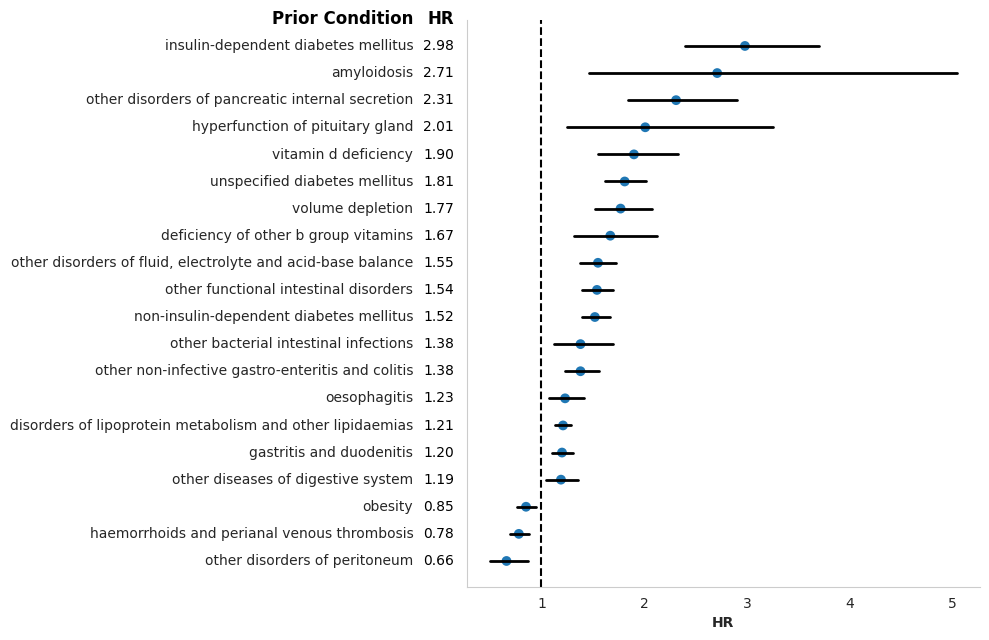

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv(f'cox_ad_lag0.tsv', sep="\t")
df_sorted = df.sort_values(by='Hazard Ratio', ascending=False)
df_sorted = df_sorted[df_sorted["FDR Corrected p"] < 0.05]

# Seaborn settings
sns.set_style("whitegrid")

# Create forest plot
fig, ax = plt.subplots(figsize=(10, 6.5))

# Use seaborn's `pointplot` to create the forest plot.
sns.pointplot(
    data=df_sorted, 
    x='Hazard Ratio', 
    y='Prior ICD10 code Description', 
    join=False,
    markers='o', 
    linestyles='', 
    scale=0.8, 
    ax=ax,
)

# Plotting the error bars (i.e., confidence intervals)
for i, (_, row) in enumerate(df_sorted.iterrows()):
    ax.plot((row['CI Min'], row['CI Max']), (i, i), 'black', linewidth=2)

# Additional styling
ax.axvline(1, color='black', linestyle='--')  # Keep the line of no effect (HR = 1)
ax.set_xlabel('HR', fontweight='bold')  # Keep your label settings
ax.set_ylabel('')  # Keep your label settings empty

# Keep the positioning of variable names and HR values
ax.set_yticklabels(df_sorted['Prior ICD10 code Description'], ha='right', va='center')
ax.yaxis.set_tick_params(pad=35)  # Keep the pad distance

# Add text annotation for HR values next to each variable name
for i, (_, row) in enumerate(df_sorted.iterrows()):
    ax.text(0.15, i, f"{row['Hazard Ratio']:.2f}", verticalalignment='center', color='black', ha='right', fontsize=10)

# Add column titles at the top
ax.text(0.15, -1, "HR", verticalalignment='center', color='black', ha='right', fontsize=12, fontweight='bold')
ax.text(-0.25, -1, "Prior Condition", verticalalignment='center', color='black', ha='right', fontsize=12, fontweight='bold')

# Remove the legend box
legend = ax.legend_
if legend is not None:
    legend.remove()

# Keep spine settings
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Keep margin adjustments
plt.subplots_adjust(left=0.25)

# Keep grid line settings
ax.xaxis.grid(False)

# # Adjust the figure size and padding
plt.tight_layout()

# Save the figure to the specified file
plt.savefig(f'forest_plot_ad.png', dpi=600, bbox_inches='tight')


## PD

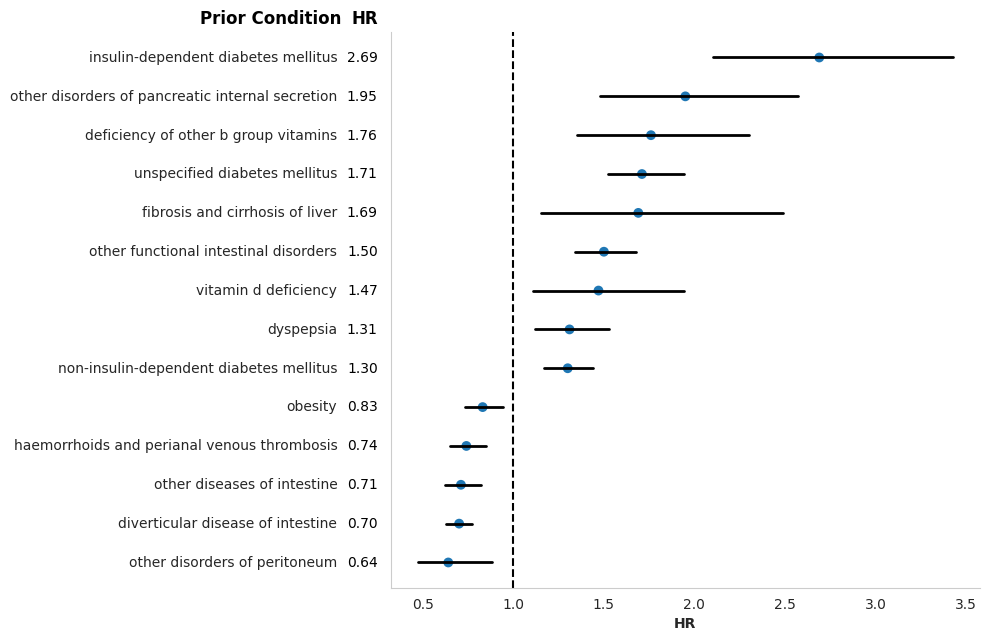

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df = pd.read_csv(f'cox_pd_lag0.tsv', sep="\t")
df_sorted = df.sort_values(by='Hazard Ratio', ascending=False)
df_sorted = df_sorted[df_sorted["FDR Corrected p"] < 0.05]

# Seaborn settings
sns.set_style("whitegrid")

# Create forest plot
fig, ax = plt.subplots(figsize=(10, 6.5))

# Use seaborn's `pointplot` to create the forest plot.
sns.pointplot(
    data=df_sorted, 
    x='Hazard Ratio', 
    y='Prior ICD10 code Description', 
    join=False,
    markers='o', 
    linestyles='', 
    scale=0.8, 
    ax=ax,
)

# Plotting the error bars (i.e., confidence intervals)
for i, (_, row) in enumerate(df_sorted.iterrows()):
    ax.plot((row['CI Min'], row['CI Max']), (i, i), 'black', linewidth=2)

# Additional styling
ax.axvline(1, color='black', linestyle='--')  # Keep the line of no effect (HR = 1)
ax.set_xlabel('HR', fontweight='bold')  # Keep your label settings
ax.set_ylabel('')  # Keep your label settings empty

# Keep the positioning of variable names and HR values
ax.set_yticklabels(df_sorted['Prior ICD10 code Description'], ha='right', va='center')
ax.yaxis.set_tick_params(pad=35)  # Keep the pad distance

# Add text annotation for HR values next to each variable name
for i, (_, row) in enumerate(df_sorted.iterrows()):
    ax.text(0.25, i, f"{row['Hazard Ratio']:.2f}", verticalalignment='center', color='black', ha='right', fontsize=10)

# Add column titles at the top
ax.text(0.25, -1, "HR", verticalalignment='center', color='black', ha='right', fontsize=12, fontweight='bold')
ax.text(0.05, -1, "Prior Condition", verticalalignment='center', color='black', ha='right', fontsize=12, fontweight='bold')

# Remove the legend box
legend = ax.legend_
if legend is not None:
    legend.remove()

# Keep spine settings
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

# Keep margin adjustments
plt.subplots_adjust(left=0.25)

# Keep grid line settings
ax.xaxis.grid(False)

# # Adjust the figure size and padding
plt.tight_layout()

# Save the figure to the specified file
plt.savefig(f'forest_plot_pd.png', dpi=600, bbox_inches='tight')
